In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark

import re
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

from scipy.sparse import csr_matrix
from pyspark.ml.feature import *

from pyspark.sql.types import *

#from pyspark.mllib.clustering import LDA, LDAModel
#from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.clustering import LDA

from pyspark.sql.functions import monotonically_increasing_id

import re as re
from pyspark.ml.feature import CountVectorizer , IDF

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Country analysis

In [2]:
avg_countryTopics=spark.read.parquet("avg_countryTopics.parquet")

In [3]:
PD_avg_countryTopics=avg_countryTopics.sort("country").toPandas()

In [4]:
PD_avg_countryTopics

,country,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,AU,0.091497,0.099690,0.033518,0.116979,0.128482,0.123456,0.052469,0.058897,0.109813,0.185199
1,BD,0.217069,0.086068,0.033162,0.129342,0.077546,0.033702,0.032931,0.042719,0.260088,0.087373
2,CA,0.111579,0.142724,0.041140,0.111449,0.109683,0.074777,0.063380,0.047377,0.122571,0.175321
3,GB,0.130282,0.083946,0.031722,0.078566,0.119837,0.082121,0.067345,0.044789,0.098546,0.262847
4,GH,0.097554,0.032976,0.017492,0.101024,0.168728,0.044519,0.038253,0.015770,0.368247,0.115437
5,HK,0.094016,0.072883,0.037030,0.319406,0.043257,0.147558,0.023440,0.029618,0.146203,0.086590
6,IE,0.106688,0.070791,0.030183,0.114474,0.205607,0.035742,0.087573,0.017370,0.080868,0.250703
7,IN,0.119563,0.078462,0.028577,0.122102,0.067669,0.077977,0.036614,0.036226,0.260474,0.172337
8,JM,0.110862,0.077505,0.044849,0.093398,0.061659,0.026636,0.073676,0.021838,0.287101,0.202476
9,KE,0.099805,0.040299,0.121060,0.237718,0.102313,0.030586,0.028764,0.021605,0.230812,0.087038


In [5]:
normalised_avg_countryTopics=PD_avg_countryTopics.set_index("country")

In [6]:
normalised_avg_countryTopics=normalised_avg_countryTopics.div(normalised_avg_countryTopics.sum(axis=1), axis=0)

In [7]:
normalised_avg_countryTopics

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
country,,,,,,,,,,
AU,0.091497,0.099690,0.033518,0.116979,0.128482,0.123456,0.052469,0.058897,0.109813,0.185199
BD,0.217069,0.086068,0.033162,0.129342,0.077546,0.033702,0.032931,0.042719,0.260088,0.087373
CA,0.111579,0.142724,0.041140,0.111449,0.109683,0.074777,0.063380,0.047377,0.122571,0.175321
GB,0.130282,0.083946,0.031722,0.078566,0.119837,0.082121,0.067345,0.044789,0.098546,0.262847
GH,0.097554,0.032976,0.017492,0.101024,0.168728,0.044519,0.038253,0.015770,0.368247,0.115437
HK,0.094016,0.072883,0.037030,0.319406,0.043257,0.147558,0.023440,0.029618,0.146203,0.086590
IE,0.106688,0.070791,0.030183,0.114474,0.205607,0.035742,0.087573,0.017370,0.080868,0.250703
IN,0.119563,0.078462,0.028577,0.122102,0.067669,0.077977,0.036614,0.036226,0.260474,0.172337
JM,0.110862,0.077505,0.044849,0.093398,0.061659,0.026636,0.073676,0.021838,0.287101,0.202476


<BarContainer object of 20 artists>

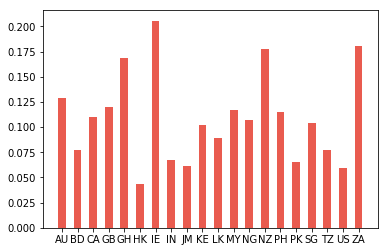

In [8]:
plt.bar(normalised_avg_countryTopics.index, normalised_avg_countryTopics['topic4'], 0.5, color="#e95b4f")

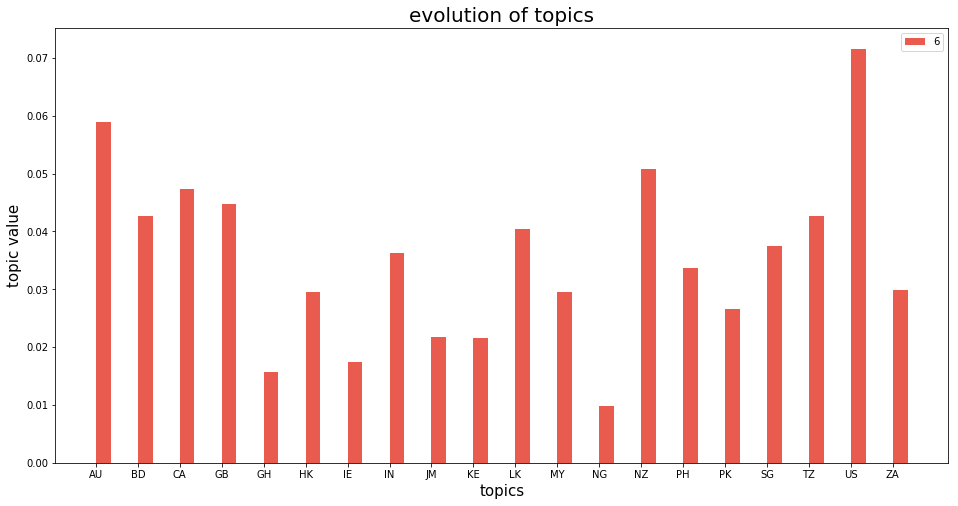

In [111]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('topics', fontsize = 15)
ax.set_ylabel('topic value', fontsize = 15)
ax.set_title('evolution of topics', fontsize = 20)

for i in range(7,8):
    ax.bar(normalised_avg_countryTopics.index, normalised_avg_countryTopics['topic'+str(i)], 0.05*i, color="#e95b4f",align='edge')
ax.legend([i for i in range(6,8)])

plt.show()

In [9]:
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(PD_avg_countryTopics.set_index("country"))
kmeans.labels_

array([2, 1, 2, 2, 0, 3, 2, 1, 1, 1, 0, 1, 0, 2, 1, 0, 3, 4, 2, 2],
      dtype=int32)

In [31]:
PD_avg_countryTopics['cluster']=kmeans.labels_

In [32]:
PD_avg_countryTopics

,country,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,cluster
0,AU,0.091497,0.099690,0.033518,0.116979,0.128482,0.123456,0.052469,0.058897,0.109813,0.185199,2
1,BD,0.217069,0.086068,0.033162,0.129342,0.077546,0.033702,0.032931,0.042719,0.260088,0.087373,1
2,CA,0.111579,0.142724,0.041140,0.111449,0.109683,0.074777,0.063380,0.047377,0.122571,0.175321,2
3,GB,0.130282,0.083946,0.031722,0.078566,0.119837,0.082121,0.067345,0.044789,0.098546,0.262847,2
4,GH,0.097554,0.032976,0.017492,0.101024,0.168728,0.044519,0.038253,0.015770,0.368247,0.115437,0
5,HK,0.094016,0.072883,0.037030,0.319406,0.043257,0.147558,0.023440,0.029618,0.146203,0.086590,3
6,IE,0.106688,0.070791,0.030183,0.114474,0.205607,0.035742,0.087573,0.017370,0.080868,0.250703,2
7,IN,0.119563,0.078462,0.028577,0.122102,0.067669,0.077977,0.036614,0.036226,0.260474,0.172337,1
8,JM,0.110862,0.077505,0.044849,0.093398,0.061659,0.026636,0.073676,0.021838,0.287101,0.202476,1
9,KE,0.099805,0.040299,0.121060,0.237718,0.102313,0.030586,0.028764,0.021605,0.230812,0.087038,1


In [33]:
PCA_countries=PD_avg_countryTopics

In [34]:
# Separating out the features
x = PCA_countries.drop(columns=['country','cluster'])
c_names=PCA_countries['country']
y=PCA_countries.cluster

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['p1', 'p2'])

In [36]:
finalDf = pd.concat([principalDf, PCA_countries[['cluster']]], axis = 1)

In [37]:
finalDf

,p1,p2,cluster
0,-0.129984,0.017285,2
1,0.077947,-0.014587,1
2,-0.111332,-0.006037,2
3,-0.163090,-0.065900,2
4,0.138014,-0.069736,0
5,-0.020928,0.219929,3
6,-0.177326,-0.065423,2
7,0.028675,-0.023459,1
8,0.039616,-0.085150,1
9,0.054350,0.086989,1


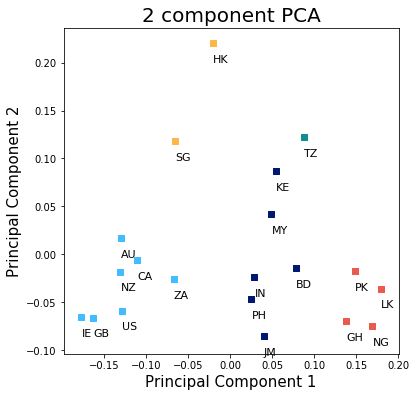

In [38]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors=['#e95b4f','#001871','#43bcff','#ffb743','#138d90','lightseagreen']
for i,name in enumerate(c_names):
    x = finalDf['p1'][i]
    y = finalDf['p2'][i]
    plt.scatter(x, y, marker="s", color=colors[finalDf['cluster'][i]])
    plt.text(x, y-0.02, name, fontsize=11)
plt.show()

## Time Analysis

In [66]:
avg_dateTopics=spark.read.parquet("avg_dateTopics.parquet")

In [67]:
PD_avg_dateTopics=avg_dateTopics.orderBy("year","month").toPandas()

In [68]:
from datetime import datetime

In [69]:
PD_avg_dateTopics['date'] = PD_avg_dateTopics.apply(lambda row: datetime(
                              int(row['year']), int(row['month']), 1), axis=1)

In [76]:
PD_avg_dateTopics=PD_avg_dateTopics.drop(['year','month'],1)

In [78]:
PD_avg_dateTopics=PD_avg_dateTopics.set_index("date")

In [79]:
normalised_avg_dateTopics=PD_avg_dateTopics.div(PD_avg_dateTopics.sum(axis=1), axis=0)

In [93]:
for i in range(10):
    normalised_avg_dateTopics['movAVG'+str(i)]=normalised_avg_dateTopics['topic'+str(i)].rolling(window=3).mean()

In [94]:
normalised_avg_dateTopics

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,movAVG0,movAVG1,movAVG2,movAVG3,movAVG4,movAVG5,movAVG6,movAVG7,movAVG8,movAVG9
date,,,,,,,,,,,,,,,,,,,,
2010-01-01,0.114495,0.114095,0.036123,0.074138,0.084033,0.102255,0.065390,0.055408,0.102394,0.251668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01,0.112260,0.098107,0.037372,0.080054,0.085577,0.103522,0.065373,0.058688,0.104405,0.254641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,0.118147,0.096756,0.037807,0.081446,0.078824,0.102371,0.065506,0.057916,0.107105,0.254123,0.114967,0.102986,0.037101,0.078546,0.082811,0.102716,0.065423,0.057338,0.104635,0.253477
2010-04-01,0.113884,0.103040,0.036930,0.082044,0.074532,0.104288,0.063305,0.063227,0.109185,0.249564,0.114764,0.099301,0.037369,0.081181,0.079644,0.103394,0.064728,0.059944,0.106898,0.252776
2010-05-01,0.113591,0.101899,0.036662,0.078070,0.076726,0.098946,0.066842,0.064804,0.116567,0.245891,0.115208,0.100565,0.037133,0.080520,0.076694,0.101868,0.065218,0.061983,0.110952,0.249860
2010-06-01,0.108478,0.100534,0.037769,0.078412,0.090183,0.097586,0.062554,0.063502,0.105999,0.254983,0.111984,0.101825,0.037120,0.079509,0.080480,0.100273,0.064234,0.063844,0.110584,0.250146
2010-07-01,0.114895,0.104982,0.041003,0.079266,0.083870,0.090396,0.060218,0.063402,0.103223,0.258745,0.112321,0.102472,0.038478,0.078583,0.083593,0.095643,0.063205,0.063903,0.108596,0.253207
2010-08-01,0.111005,0.104191,0.042809,0.077370,0.079888,0.093818,0.063770,0.066037,0.109042,0.252070,0.111459,0.103236,0.040527,0.078349,0.084647,0.093933,0.062181,0.064314,0.106088,0.255266
2010-09-01,0.108764,0.098951,0.038294,0.079986,0.077640,0.094279,0.062066,0.057033,0.117447,0.265541,0.111554,0.102708,0.040702,0.078874,0.080466,0.092831,0.062018,0.062158,0.109904,0.258786


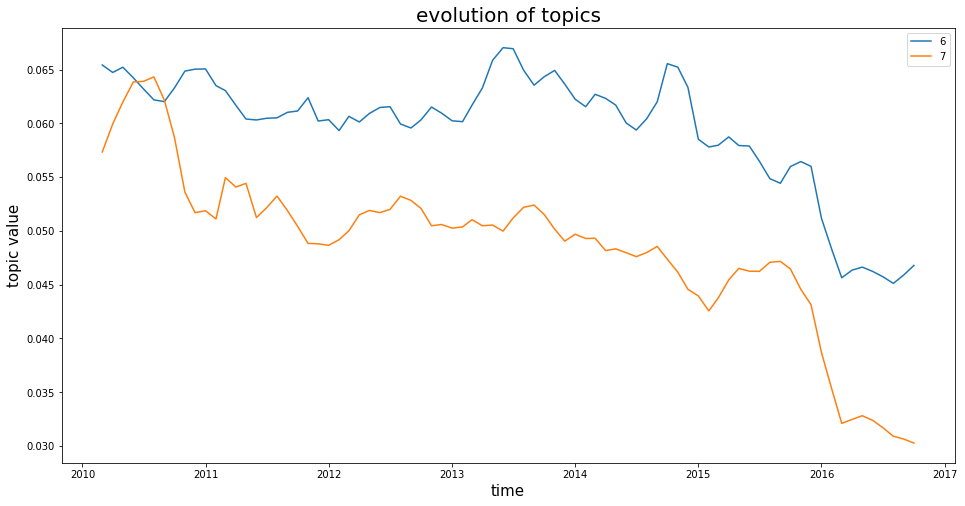

In [100]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('time', fontsize = 15)
ax.set_ylabel('topic value', fontsize = 15)
ax.set_title('evolution of topics', fontsize = 20)
for i in range(6,8):
    plt.plot(normalised_avg_dateTopics.index,normalised_avg_dateTopics['movAVG'+str(i)])
ax.legend([i for i in range(6,8)])

plt.show()

## Press freedom corrolation

In [286]:
press_freedom=pd.read_csv("DATA_PRESS_0.csv")

In [287]:
press_freedom

,country,freedom
0,JM,"11,33"
1,NZ,"13,62"
2,IR,"14,59"
3,CA,"15,28"
4,AU,"15,46"
5,GH,"18,41"
6,ZA,"20,39"
7,GB,"23,25"
8,US,"23,73"
9,HK,"29,04"


In [290]:
press_index=PD_avg_countryTopics

In [291]:
# Separating out the features
x = PCA_countries.drop(columns=['country','cluster'])
c_names=PCA_countries['country']
y=PCA_countries.cluster

In [293]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['p1'])

In [295]:
finalDf = pd.concat([principalDf, PCA_countries[['country']]], axis = 1)

In [296]:
freedom_DF = pd.merge(finalDf, press_freedom, on='country')

In [297]:
freedom_DF

,p1,country,freedom
0,0.107458,AU,"15,46"
1,-0.096324,BD,"48,62"
2,0.099825,CA,"15,28"
3,0.146126,GB,"23,25"
4,-0.075679,GH,"18,41"
5,-0.047816,HK,"29,04"
6,-0.067001,IN,"43,24"
7,0.006150,JM,"11,33"
8,-0.057516,KE,"30,82"
9,-0.136351,LK,"41,37"


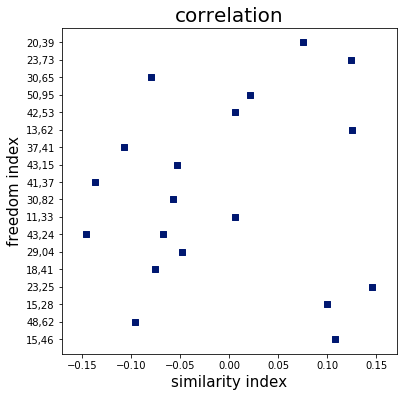

In [298]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('similarity index', fontsize = 15)
ax.set_ylabel('freedom index', fontsize = 15)
ax.set_title('correlation', fontsize = 20)
colors=['#e95b4f','#001871','#43bcff','#ffb743','#138d90','lightseagreen']
plt.scatter(freedom_DF['p1'], freedom_DF['freedom'], marker="s", color='#001871')
plt.show()